## Modelling Corn Plant Disease Classification with EfficientNet
# Summary & How to Use

The use of this web utlity platform is to let users of the internet upload pictures of corn plant images, have it be classified and get a determination output as to what kind of disease it shows. The platform will be UI/UX friendly for everyone of age, showing relevancy of informations about the indicated diseases. It is an integrated system of web development and AI modelling.

In [1]:
%%bash

python3 -m venv --system-site-packages ./venv

In [2]:
%%bash

source ./venv/bin/activate
pip install --upgrade pip
#pip list

In [3]:
 
%pip install --upgrade -q Pillow
%pip install -q tensorflow
%pip install -q keras
%pip install -q split-folders

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import sys
import numpy as np
import splitfolders
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout



2022-04-10 06:48:39.294362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-10 06:48:39.294436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
base_path = "./data"
data_dir = base_path + "/corn"
train_dir = base_path + "/train"
test_dir = base_path + "/test"
valid_dir = base_path + "/val"
diseases = os.listdir(data_dir)


In [6]:
# the ratio to split the data which goes into 60% training, 20% validation, 20% test
splitfolders.ratio(data_dir, base_path, seed=1337, ratio=(0.6, 0.2, 0.2), group_prefix=None)

print(diseases)
print("\nTotal disease classes are: {}".format(len(diseases)))

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']

Total disease classes are: 4


### Exploring the Data

In [7]:
# Exploring the data gathered
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(data_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])
print(img_per_class)

n_train = 0
for val in nums.values():
    n_train += val
print(f"\nThere are {n_train} images in total for training")

                                                    No. of images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot            513
Corn_(maize)___Common_rust_                                  1192
Corn_(maize)___Northern_Leaf_Blight                           985
Corn_(maize)___healthy                                       1162

There are 3852 images in total for training


Text(0.5, 1.0, 'Images per each class of plant disease')

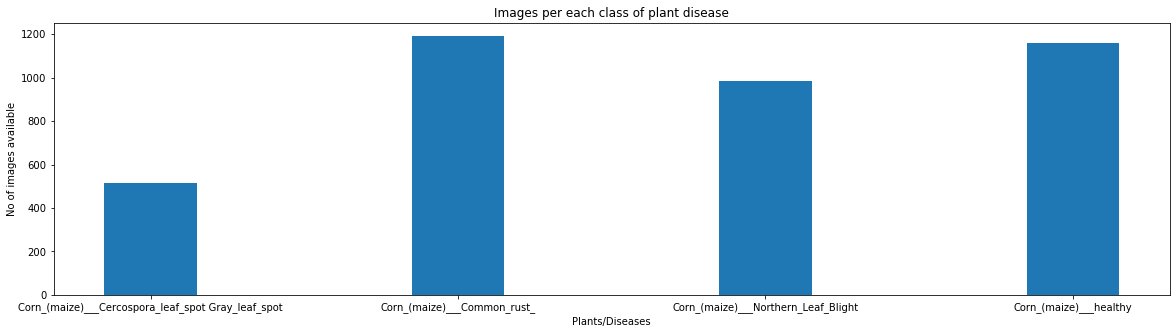

In [8]:
index = [n for n in range(4)]
plt.figure(figsize=(20,5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases')
plt.ylabel('No of images available')
plt.xticks(index, diseases)
plt.title('Images per each class of plant disease')

### Preparing the Data for Training

In any machine learning project, it is critical to set up a trustworthy validation scheme, in order to properly evaluate and compare models. This is especially true if the dataset is small which is the case of this project. For a typical image classification problem, the standard approach is to take a deep CNN model (such as the most popular EffcientNet) trained on ImageNet, replace the last layer so that the output dimension equals the target's dimension, and fine tune it on the specific dataset.

In [21]:
batch_size = 8
img_height = 224
img_width = 224

# Generating batches of real-time augmented images
train_gen = ImageDataGenerator(
    rescale=1/255.0, validation_split=0, fill_mode="nearest", 
    rotation_range=40, horizontal_flip=True, shear_range=0.2, zoom_range=0.2,
    preprocessing_function=preprocess_input
)
valid_gen = ImageDataGenerator(rescale=1/255.0, validation_split=0)
test_gen = ImageDataGenerator(rescale=1/255.0)

train_gen
valid_gen
test_gen

train_data = train_gen.flow_from_directory(directory=train_dir, target_size=(224, 224), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

valid_data = valid_gen.flow_from_directory(directory=valid_dir, target_size=(224, 224), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

test_data = test_gen.flow_from_directory(directory=test_dir, target_size=(224, 224), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

# Pulling out images and labels from sets for visualization
train_imgs, train_labels = next(train_data)
valid_imgs, valid_labels = next(valid_data)
test_imgs, test_labels = next(test_data)

print(train_data.class_indices)
# for data_batch, labels_batch in train_data:
#     print("Train Data Shape: ", data_batch.shape)
#     print("Train Label Shape: ", labels_batch.shape)
#     break

Found 2310 images belonging to 4 classes.
Found 769 images belonging to 4 classes.
Found 773 images belonging to 4 classes.
{'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0, 'Corn_(maize)___Common_rust_': 1, 'Corn_(maize)___Northern_Leaf_Blight': 2, 'Corn_(maize)___healthy': 3}


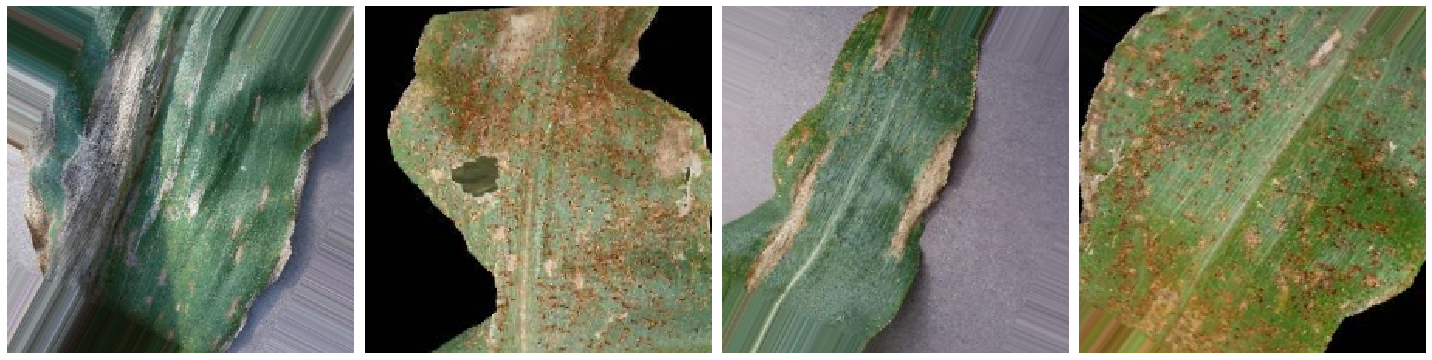

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(train_imgs[:4], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model 1

In [22]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

scheduler(10, 1e-2)

checkpoint = ModelCheckpoint('final_effinet_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.001)
learning_rate = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, learning_rate]

In [23]:
effinet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

# x = AveragePooling2D(pool_size=(7, 7))(effinet_model.output)
# x = Flatten()(x)
# predictors = Dense(4, activation="softmax", name="predictions")(x)
# final_effinet_model = Model(effinet_model.input, outputs=predictors)

final_effinet_model = Sequential()
final_effinet_model.add(effinet_model)
final_effinet_model.add(Flatten())
final_effinet_model.add(Dropout(0.2))
final_effinet_model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)))
final_effinet_model.add(Dropout(0.2))
final_effinet_model.add(Dense(4, activation="softmax"))

# Freeze the pretrained weights
for layer in final_effinet_model.layers[:1]:
    layer.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
final_effinet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



In [24]:
final_effinet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_4 (Dropout)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                4014144   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 8,063,975
Trainable params: 4,014,404
No

In [14]:
image_batch, label_batch = next(iter(train_data))
feature_batch = effinet_model(image_batch)
print(feature_batch.shape)

(4, 7, 7, 1280)


In [25]:
epochs = 10
hist = final_effinet_model.fit(train_data, epochs=epochs, validation_data=valid_data, steps_per_epoch=100, callbacks=callbacks_list)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 13.0743 - accuracy: 0.2875
Epoch 1: val_loss improved from inf to 1.97380, saving model to final_effinet_model.h5
100/100 [==============================] - 102s 938ms/step - loss: 13.0743 - accuracy: 0.2875 - val_loss: 1.9738 - val_accuracy: 0.3017 - lr: 0.0100
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 1.8594 - accuracy: 0.2932
Epoch 2: val_loss improved from 1.97380 to 1.74418, saving model to final_effinet_model.h5
100/100 [==============================] - 93s 928ms/step - loss: 1.8594 - accuracy: 0.2932 - val_loss: 1.7442 - val_accuracy: 0.3095 - lr: 0.0100
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.6651 - accuracy: 0.3000
Epoch 3: val_loss improved from 1.74418 to 1.61817, saving model to final_effinet_model.h5
100/100 [==============================] - 90s 906ms/step - loss: 1.6651 - accuracy: 0.3000 - val_loss: 1.6182 - val_accuracy: 0.3095 - lr: 0.0100

In [ ]:
if os.path.isfile('./final_effinet_model.h5') is False:
    final_effinet_model.save('./final_effinet_model.h5')

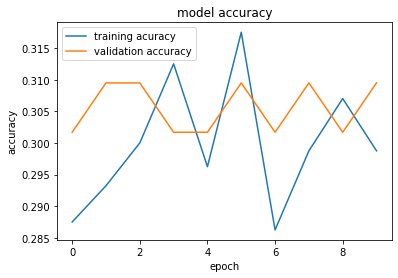

In [26]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["training acuracy", "validation accuracy"], loc="upper left")
    plt.show()

plot_hist(hist)

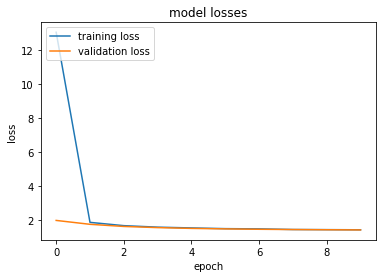

In [27]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model losses")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["training loss", "validation loss"], loc="upper left")
    plt.show()

plot_hist(hist)